In [2]:
import qiskit_nature
from rdkit import Chem
from pathlib import Path 

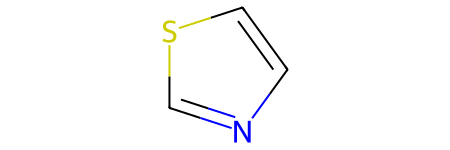

In [3]:
smile='C1=CSC=N1'
smi_key='Thiazole'
mol_rdkit = Chem.MolFromSmiles(smile)
mol_rdkit

In [4]:
 import py3Dmol 

In [5]:

def view3D(mol, label, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400)       # visualiser la molécule avec une largeur de ''400'' et hauteur de ''400''

        if fmt=='mol':                                   # si le format des 'mol',
            view.addModel(Chem.MolToMolBlock(mol), fmt)     # generer les coordonnes de a molecule dans un block
            # view.addModel(mol, fmt)
        elif fmt=='xyz':                                      # sinon 
            view.addModel(mol, fmt)                             # generer les coordonnes en xyz

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}})     # définir le style de représentation de la molécule, avec des bâtons pour les liaisons et des sphères pour les atomes avec une échelle de '30'
        view.addLabel(label, {'position': {'x': -2, 'y': -3, 'z': 0}}) # ajouter une etiquette de visualisation dont les coordonnées sont x,y,z

        view.zoomTo()
        view.show()

Meilleur conformere

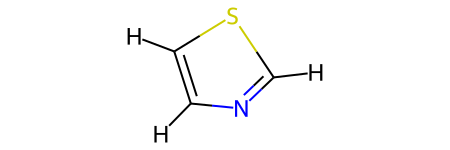

In [6]:
from rdkit.Chem import AllChem

# Add explicit Hs
mol_rdkit = Chem.AddHs(mol_rdkit)    #   Ajouter les atomes d'hydrogene a la molécule

# Generates the initial 3D conformation of the molecule
AllChem.EmbedMolecule(mol_rdkit)
mol_rdkit

Visualisatio 3D

In [7]:
# 3D visualization
mol_rdkit0 = mol_rdkit                    #crée une nouvelle variable mol_rdkit0 qui est une copie de mol_rdkit.
                                           #Cette copie est nécessaire pour la visualisation 3D, car la fonction view3D() modifie l'objet molécule passé en argument.

view3D(mol_rdkit0, f'{smi_key} RDKit Molecule')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
# Convert RDKit molecule to XYZ format 
mol_xyz0 = Chem.MolToXYZBlock(mol_rdkit)    # Convertir  la molecule format XYZ 
print(mol_xyz0)

8

C     -0.629972   -0.732056    0.014525
C     -1.054678    0.601653    0.016497
S      0.436004    1.515214    0.226338
C      1.492643   -0.063002    0.288846
N      0.662480   -0.858628    0.160870
H     -1.396102   -1.516840   -0.105550
H     -2.082068    0.989155   -0.088716
H      2.571693    0.064503    0.420074



Preoptimosation avec rdkit

In [9]:
from rdkit.Chem import AllChem

# Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")   # utiliser 200 itérations et la variante MMFF94s

#Canonicalize the orientation of the conformation
Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

# 3D visualization
mol_rdkit1 = mol_rdkit
view3D(mol_rdkit1, f'{smi_key} RDKit Molecule MMFF94')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
# Convert RDKit molecule to XYZ format 
mol_xyz0 = Chem.MolToXYZBlock(mol_rdkit)    # Convertir  la molecule format XYZ 
print(mol_xyz0)

8

C     -0.691649   -0.720224   -0.000001
C     -0.954693    0.633220    0.000000
S      0.520142    1.509220   -0.000003
C      1.377142    0.022332    0.000002
N      0.644690   -1.070005    0.000002
H     -1.442497   -1.501087   -0.000002
H     -1.912037    1.133607    0.000002
H      2.458901   -0.007063   -0.000001



Supppression des deux premieres lignes 

In [11]:

# Remove the first two lines (number of atoms and empty line) from XYZ data
mol_xyz1 = '\n'.join(mol_xyz0.strip().split('\n')[2:])

# Check that the xyz file is valide for the next step (pyscf.gto)
print(mol_xyz1)

C     -0.691649   -0.720224   -0.000001
C     -0.954693    0.633220    0.000000
S      0.520142    1.509220   -0.000003
C      1.377142    0.022332    0.000002
N      0.644690   -1.070005    0.000002
H     -1.442497   -1.501087   -0.000002
H     -1.912037    1.133607    0.000002
H      2.458901   -0.007063   -0.000001


In [18]:
from qiskit_nature.second_q.drivers import PySCFDriver ,MethodType # Nous travaillons avec le driver PySCF

# Renseigner la structure de la molécule 
Thiazole_driver = PySCFDriver(
    atom=mol_xyz1, #Coordonnées xyz Thiazole
    basis='3-21G', #'def2-SVP', # Ensemble de base
    method = MethodType.RKS 
)
Thiazol = Thiazole_driver.run_pyscf() 
mol=Thiazole_driver._mol     
mf = Thiazole_driver._calc  

Affichage de quelques informations sur la molecule

In [19]:
print(f'Le nombre total d\'électrons est {mol.nelectron} \
et le nombre total d\'électrons (alpha, béta) est {mol.nelec}\n')
print(f'Les index (0-Based) du (HOMO,LUMO) sont {mol.nelectron//2 -1, mol.nelectron//2}\n')
print(f'Le nombre d\'orbitales atomiques, dans la base {mol.basis}, est {mol.nao}\n')
print(f'L\'énergie nucléaire vaut {mol.energy_nuc()} Hartrees')

Le nombre total d'électrons est 44 et le nombre total d'électrons (alpha, béta) est (22, 22)

Les index (0-Based) du (HOMO,LUMO) sont (21, 22)

Le nombre d'orbitales atomiques, dans la base 3-21G, est 55

L'énergie nucléaire vaut 204.83945839928373 Hartrees


Tracé de la courbe des orbitales avec la fonction plotly.express

In [20]:
import plotly.express as px

# Plot the MO Occupations
fig = px.line(y=mf.mo_occ, markers=True, title="Molecular Orbital (MO) Occupations")
fig.update_layout(xaxis_title="Orbital Index (0-Based)", yaxis_title="MO Occupation")
fig.show()